In [1]:
import cv2
import json
import time
import numpy as np
import mediapipe as mp
import tensorflow as tf
from collections import deque
from concurrent.futures import ThreadPoolExecutor
import os
import pandas as pd

tf.get_logger().setLevel('ERROR')

In [ ]:
import cv2
import os

# Directory to save the new gesture images
new_gesture_dir = "none"

# Create directory if it doesn't exist
if not os.path.exists(new_gesture_dir):
    os.makedirs(new_gesture_dir)

# Initialize webcam
cap = cv2.VideoCapture(0)

# Counter for saved images
img_counter = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        break

    cv2.imshow("Collecting New Gesture", frame)
    
    # Press 'c' to capture an image
    key = cv2.waitKey(1)
    if key == ord('c'):
        img_name = os.path.join(new_gesture_dir, "gesture_{}.png".format(img_counter))
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1
    # Press 'q' to quit
    elif key == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()


In [2]:
filtered_hand = list(range(21))

HAND_NUM = len(filtered_hand)

In [3]:
hands = mp.solutions.hands.Hands()
pose = mp.solutions.pose.Pose()
def get_hands_landmarks(frame):
    results_hands = hands.process(frame)
    hand_lm = np.zeros((HAND_NUM * 2, 3))
    if results_hands.multi_hand_landmarks:
        for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
            if results_hands.multi_handedness[i].classification[0].index == 0: 
                hand_lm[:HAND_NUM, :] = np.array(
                    [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # right
            else:
                hand_lm[HAND_NUM:HAND_NUM * 2, :] = np.array(
                    [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # left
    return hand_lm

In [4]:
def load_dataset(dataset_dir):
    dataset = []
    labels = []

    gesture_names = os.listdir(dataset_dir)
    for gesture_name in gesture_names:
        gesture_dir = os.path.join(dataset_dir, gesture_name)

        if os.path.isdir(gesture_dir):
            for filename in os.listdir(gesture_dir):
                image_path = os.path.join(gesture_dir, filename)
                image = cv2.imread(image_path)

                dataset.append(image)
                labels.append(gesture_name)

    return dataset, labels

In [5]:
dataset_dir = 'dataset'

dataset, labels = load_dataset(dataset_dir)

In [6]:
len(labels)

412

In [7]:
all_landmarks = []
new_labels = []
deleted = 0
L = 0
for img in dataset:
    try:
        lm = get_hands_landmarks(img)
        all_landmarks.append(lm)
        new_labels.append(labels[L])
        L += 1
    except Exception as e:
        print(e)
        L += 1
        deleted += 1
        continue
    # all_landmarks.append(lm)
landmarks = np.array(all_landmarks)
labels = np.array(new_labels)

In [8]:
deleted, landmarks.shape, len(new_labels)

(0, (412, 42, 3), 412)

In [9]:
landmarks = np.load('landmarks.npz')
labels = np.load('labels.npz')
landmarks = landmarks['arr']
labels = labels['arr']

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(landmarks, labels, test_size=0.2, random_state=42)

In [12]:
# Step 1: Load the base model
base_model = tf.keras.models.load_model('base.keras')
# Step 2: Make the base model untrainable
base_model.trainable = False

In [13]:
base_model.output_shape,base_model.input_shape

((None, 64), (None, 42, 3))

In [14]:
num_classes = len(pd.unique(labels))
num_classes

8

In [15]:
# Step 3: Add new classification layers
x = tf.keras.layers.Dense(64, activation='relu')(base_model.output)
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

In [17]:
# Step 3: Add new classification layers
x = tf.keras.layers.Dense(64, activation='relu', name='new_dense_1')(base_model.output)
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax', name='new_output_layer')(x)

# Step 4: Create the complete model
model = tf.keras.Model(inputs=base_model.input, outputs=output_layer)


In [19]:
model.input_shape,model.output_shape

((None, 42, 3), (None, 8))

In [20]:
# Step 5: Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
10/10 [==============================] - 1s 6ms/step - loss: 3.6796 - accuracy: 0.2121
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 1.7317 - accuracy: 0.3131
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 1.3720 - accuracy: 0.4646
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 1.1296 - accuracy: 0.6128
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9460 - accuracy: 0.7172
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.8243 - accuracy: 0.7407
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7393 - accuracy: 0.8013
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6739 - accuracy: 0.8384
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.8384
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5811 - accuracy: 0.8451
Epoch 11/

In [21]:
import numpy as np

# Reshape the input data
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 42, 3))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 42, 3))

# Verify the shapes
print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)


Shape of X_train_reshaped: (297, 42, 3)
Shape of X_test_reshaped: (75, 42, 3)


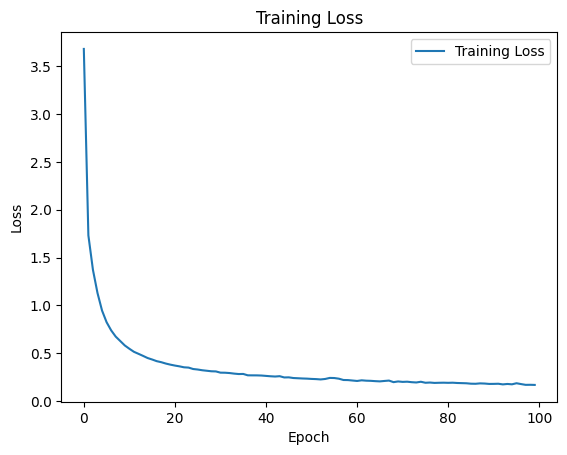

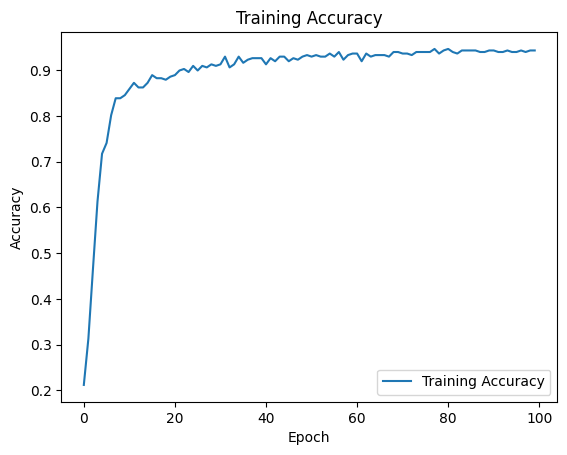

In [28]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


In [31]:
model.evaluate(X_test_reshaped,y_test)

3/3 [==============================] - 0s 8ms/step - loss: 0.4492 - accuracy: 0.8667


[0.4492451846599579, 0.8666666746139526]